In [120]:
import sys
sys.path.append('../..')

import attack
import data_loader as dl

In [220]:
import geopandas as gp
import pandas as pd
from tqdm import tqdm
import numpy as np
import libpysal
import itertools
from joblib import Parallel, delayed
import random
import matplotlib.pyplot as plt
from shapely import Point
import math
from tqdm import tqdm
tqdm.pandas()

In [221]:
# Load data
gdf = gp.read_file('full_trip_HL_clustering.geojson').to_crs(4326)

In [222]:
# format clusering_HL columns as object
gdf['clustering_HL'] = gdf['clustering_HL'].astype('object')

In [223]:
gdf['START_POINT'] = gdf.geometry.apply(lambda x: Point(x.coords[0]))
gdf['END_POINT'] = gdf.geometry.apply(lambda x: Point(x.coords[-1]))

In [ ]:
# plot trajectories of a random user and the corresponding clusters
user = random.choice(gdf['PERSON_ID'].unique())

# select random user
user_gdf = gdf[gdf['PERSON_ID'] == user]

# print nr of trajectories of user
print('Nr of trajectories of user: ', len(user_gdf))

# print nr of clusters of user
print('Nr of clusters of user: ', len(user_gdf['clustering_HL'].unique()))

# plot trajectories of user
user_gdf.explore(column='clustering_HL')


In [ ]:
# plot start and end points of user
gp.GeoDataFrame(user_gdf[['START_POINT', 'END_POINT', 'clustering_HL']], geometry='START_POINT').explore(column='clustering_HL')

In [324]:
def get_points(gdf, tessellation):
    sp = gdf[['PERSON_ID', 'TRIP_ID', 'TRIP_START', 'START_POINT', 'clustering_HL']].copy()
    ep = gdf[['PERSON_ID', 'TRIP_ID', 'TRIP_END', 'END_POINT', 'clustering_HL']].copy()


    sp['lat'] = sp.START_POINT.apply(lambda x: x.y)
    sp['lng'] = sp.START_POINT.apply(lambda x: x.x)
    ep['lat'] = ep.END_POINT.apply(lambda x: x.y)
    ep['lng'] = ep.END_POINT.apply(lambda x: x.x)

    sp = sp.rename(columns={'TRIP_START': 'datetime'})
    ep = ep.rename(columns={'TRIP_END': 'datetime'})

    sp.drop('START_POINT', axis=1, inplace=True)
    ep.drop('END_POINT', axis=1, inplace=True)

    points = pd.concat([sp, ep])
    points = gp.GeoDataFrame(points, geometry=gp.points_from_xy(points.lng, points.lat, crs='epsg:4326'))
    
    points = gp.sjoin(points, tessellation, predicate='within', how='left').drop('index_right', axis=1)
    
    return points

In [219]:
from skmob.tessellation import tilers
import skmob
from shapely.geometry import Polygon


MIN_LNG, MIN_LAT, MAX_LNG, MAX_LAT = 12.562133, 52.099718, 14.129426, 52.803108  # raw_points_gdf.geometry.total_bounds

TILE_DIAMETER_IN_METERS = (
    1500  # approximately. For h3 the most appropriate resolution is found
)
TILE_TYPE = "squared"  # other option: "squared", "h3_tessellation"
####################################################################

base_shape = gp.GeoDataFrame(
    index=[0],
    crs=4326,
    geometry=[
        Polygon(
            zip(
                [MIN_LNG, MAX_LNG, MAX_LNG, MIN_LNG],
                [MIN_LAT, MIN_LAT, MAX_LAT, MAX_LAT],
            )
        )
    ],
)

tessellation = tilers.tiler.get(
    TILE_TYPE,
    base_shape=base_shape,
    meters=TILE_DIAMETER_IN_METERS,
)#.drop('H3_INDEX', axis=1)

/usr/local/lib/python3.8/dist-packages/skmob/tessellation/tilers.py:117: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  base_shape = gpd.GeoSeries(cascaded_union(polygons), crs=base_shape.crs)


In [226]:
tessellation

,tile_ID,geometry
0,0,"POLYGON ((12.56213 52.09972, 12.56213 52.10799..."
1,1,"POLYGON ((12.56213 52.10799, 12.56213 52.11627..."
2,2,"POLYGON ((12.56213 52.11627, 12.56213 52.12454..."
3,3,"POLYGON ((12.56213 52.12454, 12.56213 52.13282..."
4,4,"POLYGON ((12.56213 52.13282, 12.56213 52.14109..."
...,...,...
10057,10057,"POLYGON ((14.12520 52.76516, 14.12520 52.77331..."
10058,10058,"POLYGON ((14.12520 52.77331, 14.12520 52.78146..."
10059,10059,"POLYGON ((14.12520 52.78146, 14.12520 52.78961..."
10060,10060,"POLYGON ((14.12520 52.78961, 14.12520 52.79776..."


In [228]:


def get_location_entropy(tile_id, mapped_points_gdf):
    assert isinstance(tile_id, str)
    t_trips = mapped_points_gdf.query("tile_ID == @tile_id")
    le = 0
    c_l = len(t_trips)
    for p in t_trips.clustering_HL:
        c_l_u = len(t_trips.query('clustering_HL == @p'))
        p_u_l =  c_l_u/ c_l
        le += p_u_l * math.log(p_u_l)
    return -le
        


In [257]:
def get_inverse_loc_frequency(row, loc_frequencies, points):
    
    tl_ID = str(row.tile_ID)
    cl_ID = row.clustering_HL
    
    cl_loc_freqs = loc_frequencies.query('clustering_HL == @cl_ID')
        
    tf = row.freq/cl_loc_freqs.freq.sum()
    
    idf = math.log(points.clustering_HL.nunique()/(points.query('tile_ID == @tl_ID').clustering_HL.nunique() + 1))
    
    tf_idf = tf * idf
    
    return tf_idf
    
    
    
        

In [263]:
def get_location_similarity(cl_i, cl_j, loc_frequencies, points):
    overlap_tile_ids = set(loc_frequencies.query("clustering_HL == @cl_i").tile_ID).intersection(set(loc_frequencies.query("clustering_HL == @cl_j").tile_ID))
    nr_overlapping_tiles = len(overlap_tile_ids)
    loc_sim = 0
    
    if nr_overlapping_tiles == 0:
        return loc_sim
    for t in overlap_tile_ids:
        cl_i_freq = loc_frequencies[(loc_frequencies['clustering_HL'] == cl_i) & (loc_frequencies['tile_ID'] == t)].tf_idf.iloc[0]
        cl_j_freq = loc_frequencies[(loc_frequencies['clustering_HL'] == cl_j) & (loc_frequencies['tile_ID'] == t)].tf_idf.iloc[0]
        
        loc_sim += points.query("tile_ID == @t").location_entropy.iloc[0] * min(cl_i_freq, cl_j_freq)
    return loc_sim/nr_overlapping_tiles

In [315]:
def get_5_max(M):
    max_5 = [0,0,0,0,0]
    max_5_indices = [(0,0), (0,0), (0,0), (0,0), (0,0)]
    
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            if not all(x > M[i,j] for x in max_5):
                index_smallest_val = max_5.index(sorted(max_5, reverse=False)[0])
                max_5[index_smallest_val] = M[i,j]
                max_5_indices[index_smallest_val] = (i, j)
    
    print('Nr of links that are equal to one of max values: ', sum([sum(M == max_val).sum() for max_val in max_5]))
    return max_5_indices

get_5_max(M)

[(174, 173), (172, 174), (173, 172), (173, 174), (174, 172)]

100%|███████████████████████████████████████████████████████████████████████████████| 2750/2750 [02:00<00:00, 22.90it/s]
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


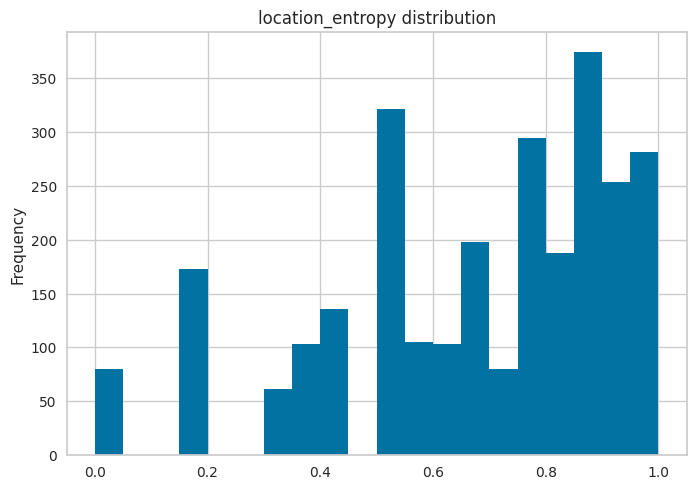

100%|█████████████████████████████████████████████████████████████████████████████████| 253/253 [02:15<00:00,  1.87it/s]


New links of clusters:
213 7
128 45
183 25
45 128
25 183
Homogeneity: 0.883
Completeness: 0.733
V-measure: 0.801
Rand index: 0.982
ARI: 0.497
MI: 3.474
NMI: 0.801
AMI: 0.673
Cluster accuracy: 0.561


100%|███████████████████████████████████████████████████████████████████████████████| 2750/2750 [02:00<00:00, 22.88it/s]
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial

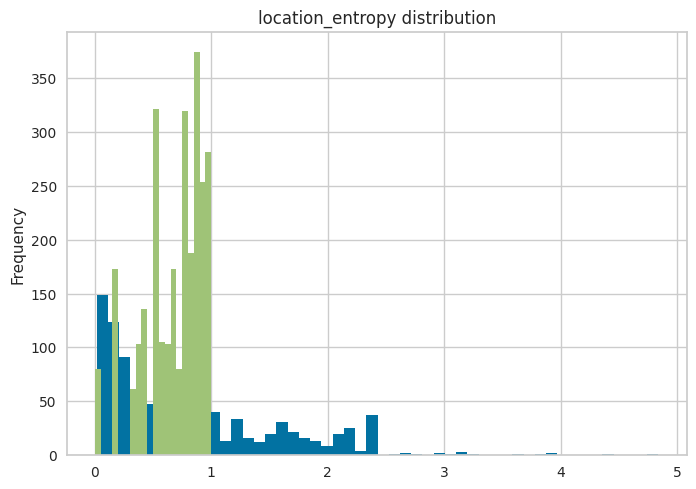

100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [02:08<00:00,  1.95it/s]


New links of clusters:
244 217
217 244
94 217
111 148
148 111
Homogeneity: 0.883
Completeness: 0.734
V-measure: 0.801
Rand index: 0.982
ARI: 0.498
MI: 3.472
NMI: 0.801
AMI: 0.674
Cluster accuracy: 0.561


100%|███████████████████████████████████████████████████████████████████████████████| 2750/2750 [01:57<00:00, 23.43it/s]
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial

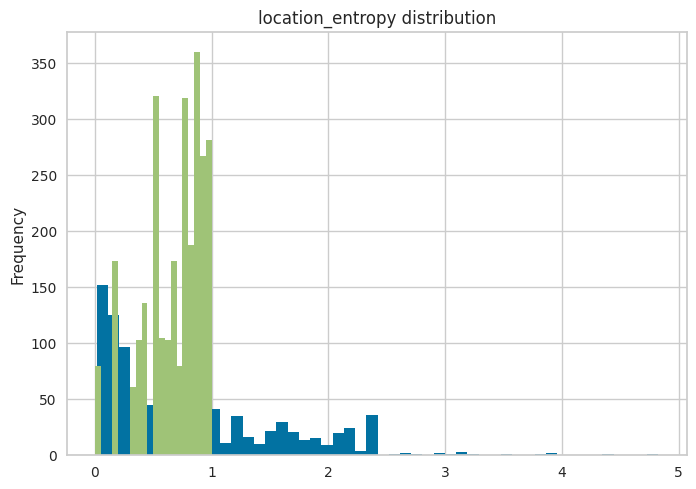

100%|█████████████████████████████████████████████████████████████████████████████████| 247/247 [02:01<00:00,  2.03it/s]


New links of clusters:
41 214
41 198
198 41
214 41
240 4
Homogeneity: 0.883
Completeness: 0.735
V-measure: 0.802
Rand index: 0.982
ARI: 0.500
MI: 3.472
NMI: 0.802
AMI: 0.677
Cluster accuracy: 0.564


100%|███████████████████████████████████████████████████████████████████████████████| 2750/2750 [01:56<00:00, 23.53it/s]
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial

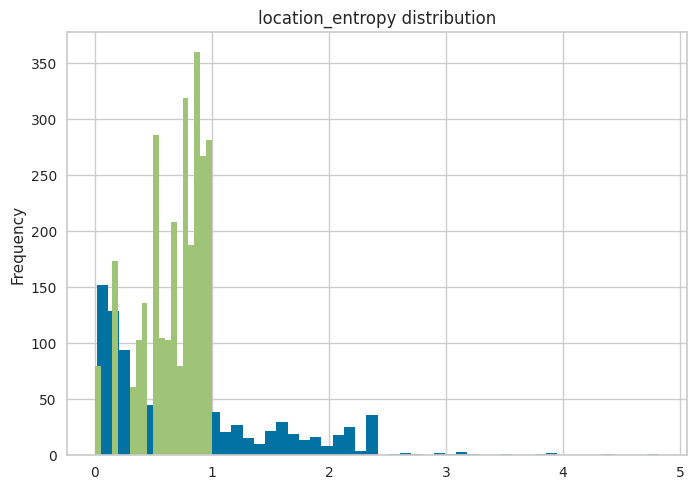

100%|█████████████████████████████████████████████████████████████████████████████████| 244/244 [01:57<00:00,  2.08it/s]


New links of clusters:
275 264
198 131
131 264
198 275
131 198
Homogeneity: 0.881
Completeness: 0.735
V-measure: 0.802
Rand index: 0.982
ARI: 0.500
MI: 3.466
NMI: 0.802
AMI: 0.676
Cluster accuracy: 0.565


100%|███████████████████████████████████████████████████████████████████████████████| 2750/2750 [01:56<00:00, 23.60it/s]
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial

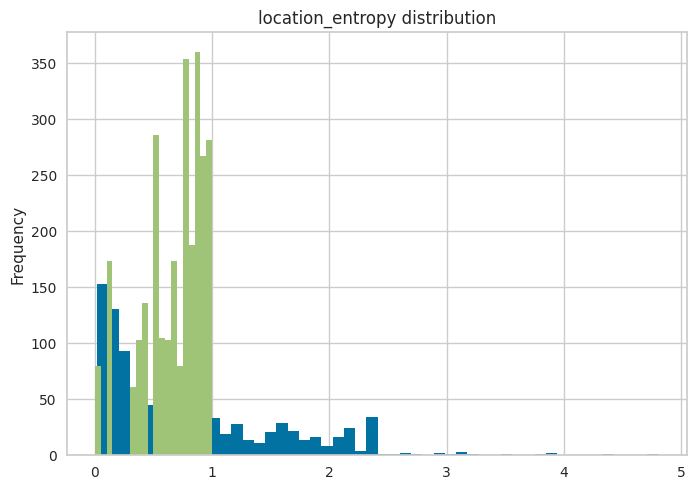

100%|█████████████████████████████████████████████████████████████████████████████████| 241/241 [01:59<00:00,  2.02it/s]


New links of clusters:
21 293
93 92
314 100
92 93
293 21
Homogeneity: 0.880
Completeness: 0.736
V-measure: 0.802
Rand index: 0.982
ARI: 0.501
MI: 3.462
NMI: 0.802
AMI: 0.677
Cluster accuracy: 0.566


100%|███████████████████████████████████████████████████████████████████████████████| 2750/2750 [01:57<00:00, 23.34it/s]
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


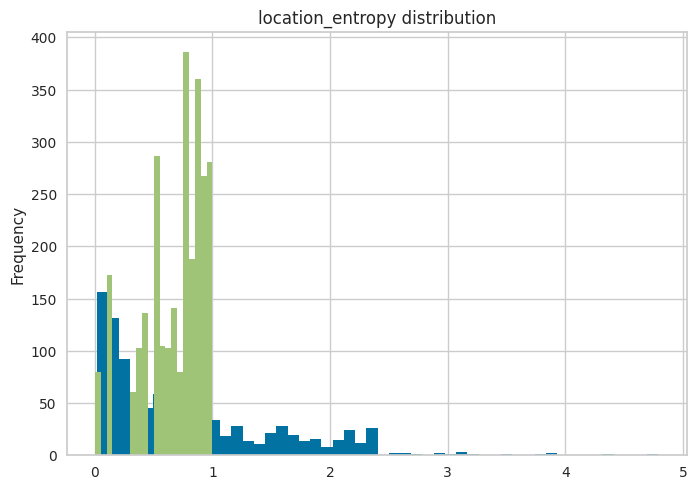

 16%|█████████████                                                                     | 38/238 [00:17<01:25,  2.34it/s]

In [332]:
for i in range(10):
    # Get new points gdf matched with tessellation that contains updated clustering column
    points = get_points(gdf, tessellation)
    
    # Compute location entropy for latest clustering
    points['location_entropy'] = points.tile_ID.progress_apply(lambda x: get_location_entropy(x, points))
    points['location_entropy'] = points.location_entropy.apply(lambda x: 1 - (x - points.location_entropy.min())/(points.location_entropy.max() - points.location_entropy.min()))
    points.location_entropy.plot.hist(bins=20, title="Inverse location_entropy distribution")
    plt.show()
    
    # Update location frequencies and loc frequency-inverse cluster frequency
    loc_frequencies = points.groupby(['clustering_HL', 'tile_ID'])[['TRIP_ID']].nunique().reset_index().sort_values('clustering_HL').rename(columns={'TRIP_ID': 'freq'})
    loc_frequencies['tf_idf'] = loc_frequencies.apply(lambda x: get_inverse_loc_frequency(x, loc_frequencies, points), axis=1)
    loc_frequencies.tf_idf.plot.hist(bins=50, title="Tf-Idf distribution")
    plt.show()
    
    # Recalculate similarities between latest clusters
    M = np.zeros((loc_frequencies.clustering_HL.nunique(), loc_frequencies.clustering_HL.nunique()))
    for i, cl_i in tqdm(enumerate(loc_frequencies.clustering_HL.unique()), total=loc_frequencies.clustering_HL.nunique()):
        for j, cl_j in enumerate(loc_frequencies.clustering_HL.unique()):
            if i == j:
                continue
            M[i, j] = get_location_similarity(cl_i, cl_j, loc_frequencies, points)
    np.fill_diagonal(M, 0)
    
    # Select 5 best links and assign new clustering IDs
    print('New links of clusters:')
    for tup in get_5_max(M):
        cl_1 = loc_frequencies.clustering_HL.unique()[tup[0]]
        cl_2 = loc_frequencies.clustering_HL.unique()[tup[1]]
        print(cl_1, cl_2)
        gdf['clustering_HL'] = gdf.clustering_HL.apply(lambda x: cl_1 if x == cl_2 else x)
    
    # Evaluate result of iteration
    attack.evaluate(gdf.clustering_HL.tolist(), gdf)